<a href="https://colab.research.google.com/github/sohumgautam17/Cell_Seg_Count-CMU/blob/main/CMU_CSegNET_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/sohumgautam17/Cell_Seg_Count-CMU.git

Cloning into 'Cell_Seg_Count-CMU'...
remote: Enumerating objects: 111, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 111 (delta 36), reused 3 (delta 1), pack-reused 0
Receiving objects: 100% (111/111), 108.49 MiB | 8.87 MiB/s, done.
Resolving deltas: 100% (36/36), done.
Updating files: 100% (66/66), done.


In [ ]:
!pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.2 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16429 sha256=fbcbd8829096bb1e6dd19c0df0a5df371e095e47319fb84effdcce008798b572
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=0fe175dc467b0038e35e164f478733ca937e68b2de55066dcae9089859cddea4
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


In [ ]:
import torch
import sklearn
import os
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import requests
from pathlib import Path
import xml.etree.ElementTree as ET
from PIL import Image
from torch import nn
import sys

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from tqdm.auto import tqdm

In [ ]:
!pwd  # Print current directory
!ls   # List contents of current directory

# Check current directory and change it if needed
if not "$(pwd)" == "/content/Cell_Seg_Count-CMU":
    %cd Cell_Seg_Count-CMU

/content
Cell_Seg_Count-CMU  sample_data
/content/Cell_Seg_Count-CMU


In [ ]:
ls

 Annotations/                 process_data.py   read_xml.py            'Tissue Images'/
 CMU_CSegNET_Pipeline.ipynb   README.md         Segmentation_Model.py  'UNET Model'


#Downloading/Parse the Data and Inspect


In [ ]:
from process_data import he_to_binary_mask

files_path = "./Tissue Images"
filename = []

for each_file in os.listdir(files_path):
  each_file = each_file[:-4]
  filename.append(each_file)

print(filename[:5])


30
30


Processing: 100%|██████████| 30/30 [01:21<00:00,  2.71s/it]


['TCGA-G9-6336-01Z-00-DX1', 'TCGA-G9-6348-01Z-00-DX1', 'TCGA-A7-A13E-01Z-00-DX1', 'TCGA-HE-7129-01Z-00-DX1', 'TCGA-21-5784-01Z-00-DX1']


In [ ]:
## testing with 2 files
filename = filename[:10]
orig_binmask_colormask = []
for i in filename:
  orig_binmask_colormask.append(he_to_binary_mask(i))

In [ ]:
###EXAMPLE VISUALIZATIONS...
image = 2
orig = orig_binmask_colormask[image-1]['original_image']
binary_mask = orig_binmask_colormask[image-1]["binary_mask"]
color_mask = orig_binmask_colormask[image-1]['color_mask']

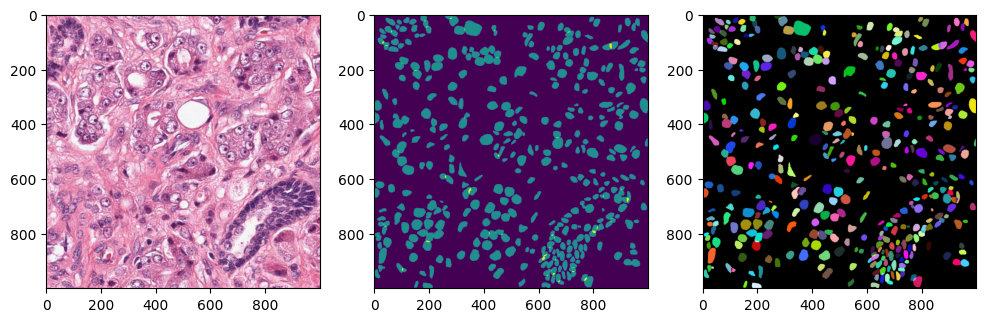

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
axes[0].imshow(orig)
axes[1].imshow(binary_mask)
axes[2].imshow(color_mask)

plt.show()

In [ ]:
len(orig_binmask_colormask[1])

3

In [ ]:
orig_binmask_colormask

[{'original_image': array([[[218, 143, 174],
          [207, 133, 168],
          [210, 136, 171],
          ...,
          [120,  76, 125],
          [127,  83, 132],
          [138,  87, 136]],
  
         [[222, 142, 179],
          [206, 131, 172],
          [203, 128, 169],
          ...,
          [137,  86, 135],
          [151, 100, 149],
          [163, 109, 159]],
  
         [[224, 141, 183],
          [204, 128, 174],
          [197, 121, 167],
          ...,
          [156,  98, 147],
          [174, 116, 165],
          [187, 129, 177]],
  
         ...,
  
         [[224, 121, 160],
          [222, 117, 157],
          [225, 120, 160],
          ...,
          [223, 177, 198],
          [224, 178, 199],
          [229, 179, 204]],
  
         [[221, 118, 157],
          [223, 118, 158],
          [227, 122, 162],
          ...,
          [216, 170, 191],
          [222, 176, 197],
          [231, 185, 206]],
  
         [[218, 113, 153],
          [223, 116, 157],
      

#Getting Data Ready for Batching

In [ ]:
X = [] # this will store all original images
y = [] # this will store all binary masked images, we can change this to color masks later, but for rn
for dictionary in orig_binmask_colormask:
  X.append(dictionary['original_image'])
  y.append(dictionary['binary_mask'])


In [ ]:
X_tensor = torch.Tensor(numpy.array(X))
X_tensor = torch.permute(X_tensor, (0, 3, 1, 2))
y_tensor = torch.Tensor(numpy.array(y))

In [ ]:
X_tensor.shape, y_tensor.shape

(torch.Size([10, 3, 1000, 1000]), torch.Size([10, 1000, 1000]))

#Setup Configs + Batching



In [ ]:
EPOCHS = 5

BATCH_SIZE = 1
LR = 0.05
test_ratio = 0.3

ENCODER = 'timm-efficientnet-b7'
WEIGHTS = 'imagenet'

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=test_ratio, random_state=42)

In [ ]:
len(X_train), len(X_test), len(y_train), len(y_test)

(7, 3, 7, 3)

In [ ]:
print(X_train.shape)
print(y_train.shape)

torch.Size([7, 3, 1000, 1000])
torch.Size([7, 1000, 1000])


In [ ]:
train_set = TensorDataset(X_train,  y_train)
test_set = TensorDataset(X_test, y_test)

In [ ]:
train_set

In [ ]:
train_loader = DataLoader(train_set, batch_size = BATCH_SIZE)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE)

In [ ]:
print(len(train_loader))
print(len(test_loader))


7
3


#Segmentation Model ... Temporary until the model file is built

In [ ]:
class SegmentationModel(nn.Module):
  def __init__(self, num_classes=1):
    super().__init__()
    #self.pad = nn.ZeroPad2d((6, 6, 6, 6))
    self.architecture = smp.Unet(
      encoder_name=ENCODER,
      encoder_weights = WEIGHTS,
      in_channels = 3,
      classes=num_classes
    )

  def forward(self, x):
    orig_h, orig_w = x.size()[-2:]
    # Apply padding to make the dimensions divisible by 32
    pad_h = ((orig_h // 32) + 1) * 32 - orig_h
    pad_w = ((orig_w // 32) + 1) * 32 - orig_w
    # Apply padding
    x = nn.ZeroPad2d((0, pad_w, 0, pad_h))(x)
    # Pass the padded input through the UNet architecture
    output = self.architecture(x)
    return output

model_0 = SegmentationModel()
model_0

SegmentationModel(
  (architecture): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (bn1): BatchNormAct2d(
              64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )


#Training Loop

In [ ]:
loss_fn = DiceLoss(mode='binary')
#loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=LR)

In [ ]:
def train(model, optimizer):
  model.train()
  total_train_loss = 0
  for epoch in tqdm(range(EPOCHS)):
    epoch_train_loss = 0
    for batch_idx, (image, annote) in enumerate(train_loader):
      print(f"Epoch #{epoch} Batch #{batch_idx}...")
      #print(annote.shape)
      #print(image.shape)
      logits = model(image)
      reshaped_logits = torch.nn.functional.pad(logits, (-12,-12,-12,-12), 'constant', value=1.2)
      #y_pred = torch.squeeze(reshaped_logits)
      #print(reshaped_logits.shape)

      loss  = loss_fn(reshaped_logits, annote)
      print(f"Batch Loss : {loss}")
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_train_loss /= len(train_loader)
      total_train_loss += epoch_train_loss


  total_train_loss /= EPOCHS
  return total_train_loss



In [ ]:
def eval(model):
  model.eval()
  total_test_loss = 0
  with torch.inference_mode():
    for image, annote in test_loader:
      test_logits = model(image)
      reshaped_logits = torch.nn.functional.pad(test_logits, (-12,-12,-12,-12), 'constant', value=1.2)
      loss = loss_fn(reshaped_logits, annote)

      total_test_loss += loss

  return total_test_loss/EPOCHS



In [ ]:
train(model_0, optimizer)

In [ ]:
from pathlib import Path

MODEL_PATH = Path("/content/Cell_Seg_Count-CMU")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "trained_seg_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
#MODEL_SAVE_PATH

print(f'Saving model to {MODEL_SAVE_PATH}')
#torch.save(model_0.state_dict(), MODEL_SAVE_PATH)

Saving model to /content/Cell_Seg_Count-CMU/trained_seg_model_0.pth


In [ ]:
eval(model_0)

tensor(0.3566)

#Inference

In [ ]:
model_0.load_state_dict(torch.load())
idx = 3
image, mask = X_test[idx], y_test[idx]

logits_mask = model(iamge)  ## unsqueeze??
pred_mask = torch.sigmoid(logits_mask)
pred_mask.shape


In [ ]:
## visualize mask
